In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC

## Загрузим данные и проведем первичный анализ

In [2]:
df = pd.read_csv('adult.csv')

In [3]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [4]:
df.shape

(48842, 15)

In [5]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
       'marital-status', 'occupation', 'relationship', 'race', 'gender',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Целевой показатель - уровень дохода имеет 2 значения: <= 50 000, > 50 000 долларов в год.

In [6]:
df['income'].unique()

array(['<=50K', '>50K'], dtype=object)

## Проверим данные на пропуски 

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [8]:
df['workclass'].value_counts()

Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

Отсутствующих значений в датасете не обнаружено, однако есть заполненные ячейки дефолтными значениями. Например, у полей `workclass`, `occupation`, `native-country` отсутвующие значения заполнены знаком "?". Решаем их для текущей задачи оставить неизменными. 

### Рассмотрим средние и крайние показатели с стандартным отклонением

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
educational-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


Кто-то работает по 99 часов в неделю! 

### Построим графики, чтобы отобразить интересные зависимости

Проверим количество персон в разрезе `workclass`, на одном графике отобразим и тех, кто зарабатывает <=50K, и тех, кто >50K

In [10]:
work = df[['workclass', 'income']].groupby(['workclass', 'income']).agg(in_cnt=('income', np.count_nonzero )).reset_index()

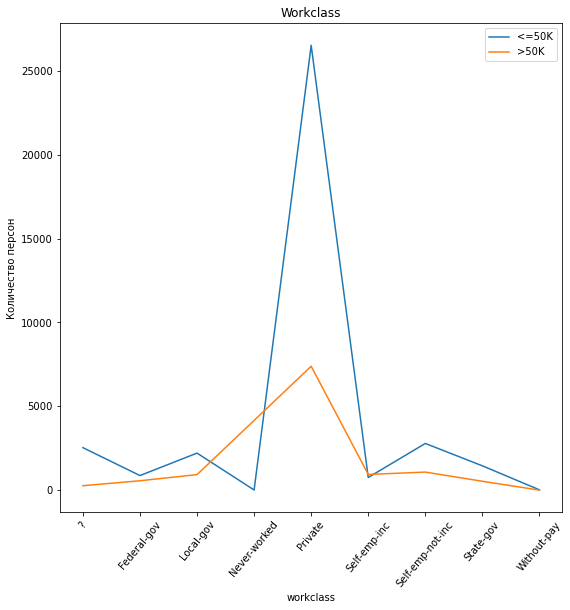

In [28]:
plt.figure(figsize=(9, 9))
plt.title('Workclass')
plt.plot(work[work.income=='<=50K']['workclass'], work[work.income=='<=50K']['in_cnt'])
plt.plot(work[work.income=='>50K']['workclass'], work[work.income=='>50K']['in_cnt'])
plt.legend(['<=50K', '>50K'])
plt.ylabel('Количество персон')
plt.xlabel('workclass')
plt.xticks(rotation=50)
plt.show()

На графике видно, что для `Private` `workclass` количество персон значительно выше в группе с доходом `<=50K`

In [12]:
edu = df[['education', 'income']].groupby(['education', 'income']).agg(in_cnt=('income', np.count_nonzero )).reset_index()

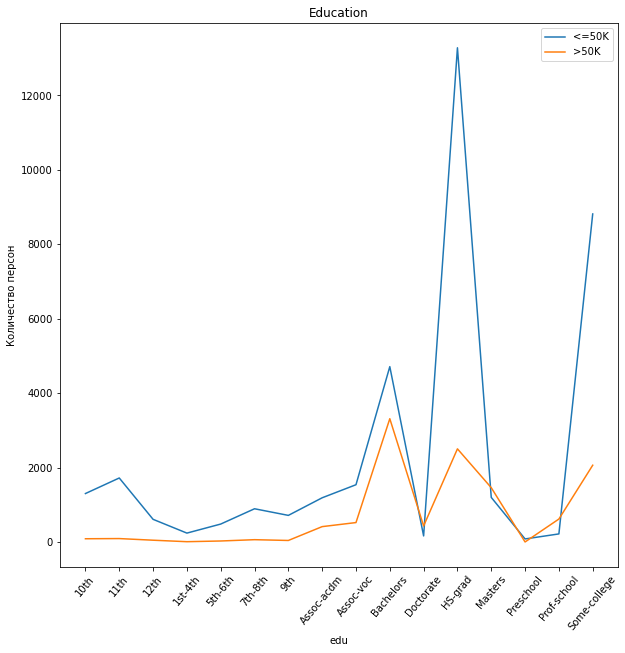

In [13]:
plt.figure(figsize=(10, 10))
plt.title('Education')
plt.plot(edu[edu.income=='<=50K']['education'], edu[edu.income=='<=50K']['in_cnt'])
plt.plot(edu[edu.income=='>50K']['education'], edu[edu.income=='>50K']['in_cnt'])
plt.legend(['<=50K', '>50K'])
plt.ylabel('Количество персон')
plt.xlabel('edu')
plt.xticks(rotation=50)
plt.show()

## Преобразование категориальных признаков в столбцы с числовыми значениями

Выберем столбц income, чтобы добавить к нему столбц income_num, в котором будут значения 0, 1

In [14]:
categ_columns = ['income']
for column in categ_columns:
    le = LabelEncoder()
    le.fit(df[column])
    df[f'{column}_num'] = pd.Series(data=le.transform(df[column]))

## Подготовка наборов данных (обучающего, тестового)

Предположим, что доход зависит от `hours-per-week`, `marital-status`, `workclass`, `education`, `age`

In [15]:
selectedColumns = df[['hours-per-week', 'marital-status', 'workclass', 'education', 'age']]

Разложим каждый категориальный стобец в группу столбцов, в которых будут лежать 0 и 1, в зависимости от того, какое значение категориального признака присвоено физлицу

In [16]:
X = pd.get_dummies(selectedColumns, columns = ['hours-per-week', 'marital-status', 'workclass', 'education'])

In [17]:
y = df['income_num']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Логистическая регрессия

In [19]:
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
#model = LogisticRegression(max_iter=2000)

In [20]:
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [21]:
model.score(X_train, y_train) 

0.8295242238886188

In [22]:
model.score(X_test, y_test)

0.8328385709898659

## Метод опорных векторов

In [23]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto')) 

In [24]:
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [25]:
clf.score(X_train, y_train)

0.8287820233921122

In [26]:
clf.score(X_test, y_test) 

0.8260825058859658

### Выводы

* В работе был произведен первичные анализ входных данных по уровню дохода физлиц.
* Выявлены столбцы в которых есть ячейки, заполненные дефолтными значениями. Решено их оставить неизменными
* Построены графики некоторых зависимостей
* Выполнены преобразования над данными:
    * Для income добавлен столбец income_num со значениями 0, 1
    * Каждый категориальный столбец разложен в группы столбцов с 0, 1
    * Выборка поделена на часть для обучения (train) и часть для проверки (test)
* Выполнено обучение логистической и SVM моделей
* Логистическая и SVM модели показали практически схожий результат: 82-83% точности
* Логистическая модель работает на laptop в разы быстрее - менее секунды против 3.5 минут (для SVM)
* Признаки (features) были подобраны наугад, в дальнейшем желательно выбирать нужные и убирать ненужные признаки